<a href="https://colab.research.google.com/github/ZosoV/aco_random_walk/blob/main/notebooks/proximities_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testing Proximity Measures

In this notebook, we aimed to study the behavior of different proximity measures. Somethings to check are how they are distributed across the environment, what is the effect of normalization and the differences or not between two types of proximities.


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/Proyectos/aco_random_walk/

/content/gdrive/MyDrive/Proyectos/aco_random_walk


In [3]:
# import necessary libraries
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import numpy as np
import random
import os

#own functions
import model.graph_env as ge
import utils.visualization as vis

### Proximity and Multiplication Step

The `proximity` represents the separation of a node to the target node.

On one hand, we have the `proximity`, which is the inverse relative distance of a neighbor node to the target node. In this section, we review the distribution of this metric in environments with different sizes. The proximity of current node $i$ respect to the neighbor node $j$ is

$$ \mathrm{proximity1}_{ij} = \frac{1}{d_{jt}} = \upsilon_{ij} $$

where $d_{jt}$ is the manhattan or euclidean distance of the neighbor node $j$ to the target node $t$.

Additionally, we propose a `proximity-2` to reduce the sparse values. This metric results from multiplying the previous proximity-1 to $d_{it}$, the distance of the current node $i$ to the target node $t$. This little change can alter the proximity values, reducing its variabality. In large environments, this variability is more noticed, because it is divided 1 by a large number $d_{jt}$ in some nodes.

$$ \mathrm{proximity2}_{ij} = \frac{d_{it}}{d_{jt}} = \upsilon_{ij} $$



In [4]:
def get_distance(pos1, pos2, distance):
  x1, y1 = pos1
  x2, y2 = pos2

  if distance == 'euclidean':
    result = np.sqrt((x2-x1)**2 + (y2-y1)**2)
  elif distance == 'manhattan':
    result = np.abs(x2-x1) + np.abs(y2-y1)

  return result

In [5]:
def get_proximity(graph, current_node, neighbor_node, target_node, 
                  mode = 'proximity_1', distance = 'euclidean'):
  """
  Proximity. Calculate the proximity of the neighbor node.
  :param graph:         graph environment
  :param current_node:  index of the current node i
  :param neighbor_node: index of the neihbor node j
  :param target_node:   index of the neihbor node t
  :param mode:          perform the proximity 1 or proximity 2
  :param distance:      used distance to calculate the proximity
  """
  pos_neighbor = graph.nodes[neighbor_node]['pos']
  pos_target = graph.nodes[target_node]['pos']
  pos_current = graph.nodes[current_node]['pos']

  # distance: current node to target
  dis_curr2target = get_distance(pos_current, pos_target, distance)
  
  # distance: neighbor to target
  dis_neig2target = get_distance(pos_neighbor, pos_target, distance)
  
  if neighbor_node == target_node:
    proximity = 1
  else:

    if mode == 'proximity_1':
      proximity = 1/ dis_neig2target
    elif mode == 'proximity_2':
      proximity = dis_curr2target / dis_neig2target

  return proximity

We created some auxiliar functions to test our results

In [6]:
# Calculate the proximities of the total environment
def get_env_proximities(graph, 
                        normalization = None, 
                        proximity_mode = 'proximity_1', 
                        distance = 'manhattan', 
                        mode = None):

  target_node = graph.size * graph.size - 1

  proximities_env = []

  for current_node in range(graph.number_of_nodes()):
    if current_node != target_node:
      neighbors = graph[current_node]

      # print("Node: ", current_node)

      tmp_proximities = []
      for neighbor_node, _ in neighbors.items():
          # get the weight per neighbor
          proximity = get_proximity(graph, 
                                      current_node,
                                      neighbor_node, 
                                      target_node,
                                      proximity_mode,
                                      distance)
          # proximities_env.append(proximity)
          tmp_proximities.append(proximity)
      
      if mode == 'local':
        tmp_proximities = normalize_array(tmp_proximities, normalization)

      proximities_env = np.concatenate((proximities_env,tmp_proximities))

  if mode == 'global':
    proximities_env = normalize_array(proximities_env, normalization)

  return proximities_env

In [7]:
graph = ge.PPGraph(size = 10, tau_0 = 0.1)
proximities_env = get_env_proximities(graph, 
                                      proximity_mode = 'proximity_1', 
                                      distance = 'manhattan')

In [8]:
proximities_options = ['proximity_1', 'proximity_2']
distance_options = ['manhattan', 'euclidean']

dict2plot = {}

for proximity_mode in proximities_options:
  for distance in distance_options:
    proximities_env = get_env_proximities(graph, 
                                      proximity_mode = proximity_mode, 
                                      distance = distance)
    title = proximity_mode + " " + distance
    dict2plot[title] = proximities_env

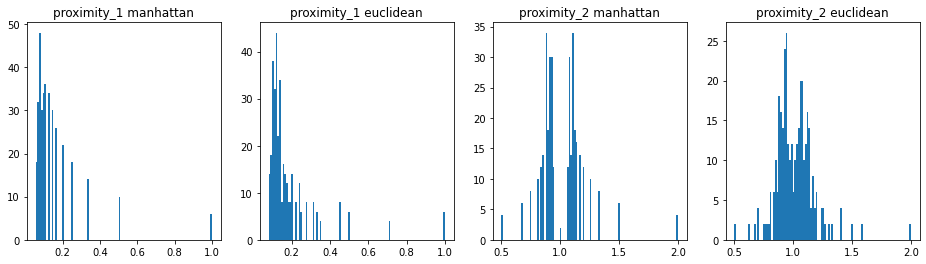

In [10]:
vis.plot_histograms(dict2plot, bins=100)

Then, another behavior that we want to check is the normalization on this metrics

### Local and Global Normalization

In this section, we wondered if it is necessary to mantain the proximity values within of acceptable range of values. In this regard, we evaluate diverse normalization steps to a global and local level.

* `global`: applies a normalization between all the proximities values of the whole environment.
* `local`: applies a normalization in each step of the walker, or, in other words, between the proximities values of the neighbor nodes belonging to $N(n^i)$.

In order to check different normalization methods, we used:

* `standard`
$$ X ^ {\prime} = \frac{X-\mu}{\sigma} $$ 

* `l2-norm`

$$ X ^ {\prime} = \frac{X}{\|\boldsymbol{x}\|_2} $$

$$ \|\boldsymbol{x}\|_{2}:=\sqrt{x_{1}^{2}+\cdots+x_{n}^{2}} $$

* `max-min`
$$ X^{\prime}=\frac{X-X_{\min }}{X_{\max }-X_{\min }} $$

In [15]:
def normalize_array(array, mode):
  if mode == 'standard':
    mean = np.mean(array)
    std = np.std(array)

    if std != 0.0:
      array = (array - mean) / std

  elif mode == 'l2-norm':
    array = array / np.linalg.norm(array)


  elif mode == 'max-min':
    max = np.amax(array)
    min = np.amin(array)
    if (max - min) != 0.0:
      array = (array - min) / (max - min)

  return array


In [16]:
#function to perform global and local experiments
def get_group_proximities(graph, mode = 'global'):
  distances_options = ['euclidean', 'manhattan']
  proximities_options = ['proximity-1', 'proximity-2']
  normalization_options = ['none', 'standard', 'l2-norm', 'max-min']

  data = {}

  for proxi_mode in proximities_options:
    for normalization in normalization_options:
      for distance_mode in distances_options:
        proximities_env = get_env_proximities(graph, 
                                              normalization = normalization, 
                                              proximity_mode = proxi_mode.replace('-','_'), 
                                              distance = distance_mode,
                                              mode = mode)
        
        id = "{}_{}_{}".format(proxi_mode, normalization, distance_mode)


        data[id] = proximities_env

  return data

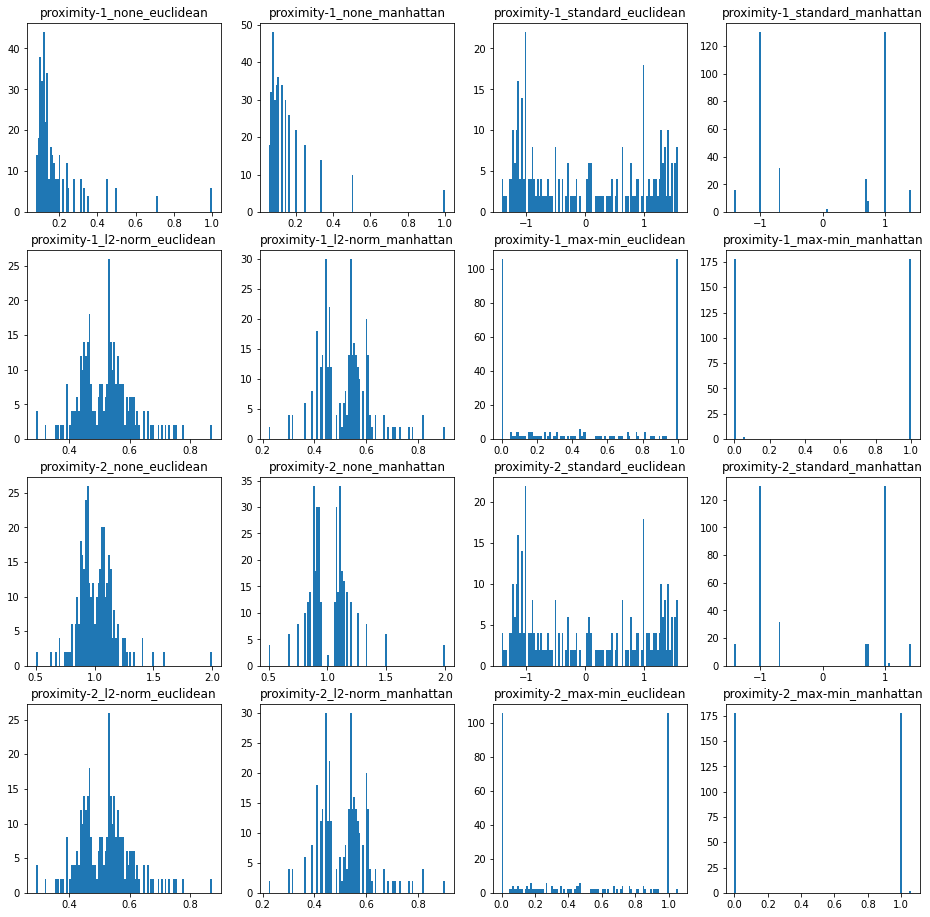

In [17]:
graph = ge.PPGraph(size = 10, tau_0 = 0.1)
dict2plot = get_group_proximities(graph, mode='local')
vis.plot_histograms(dict2plot, bins=100)

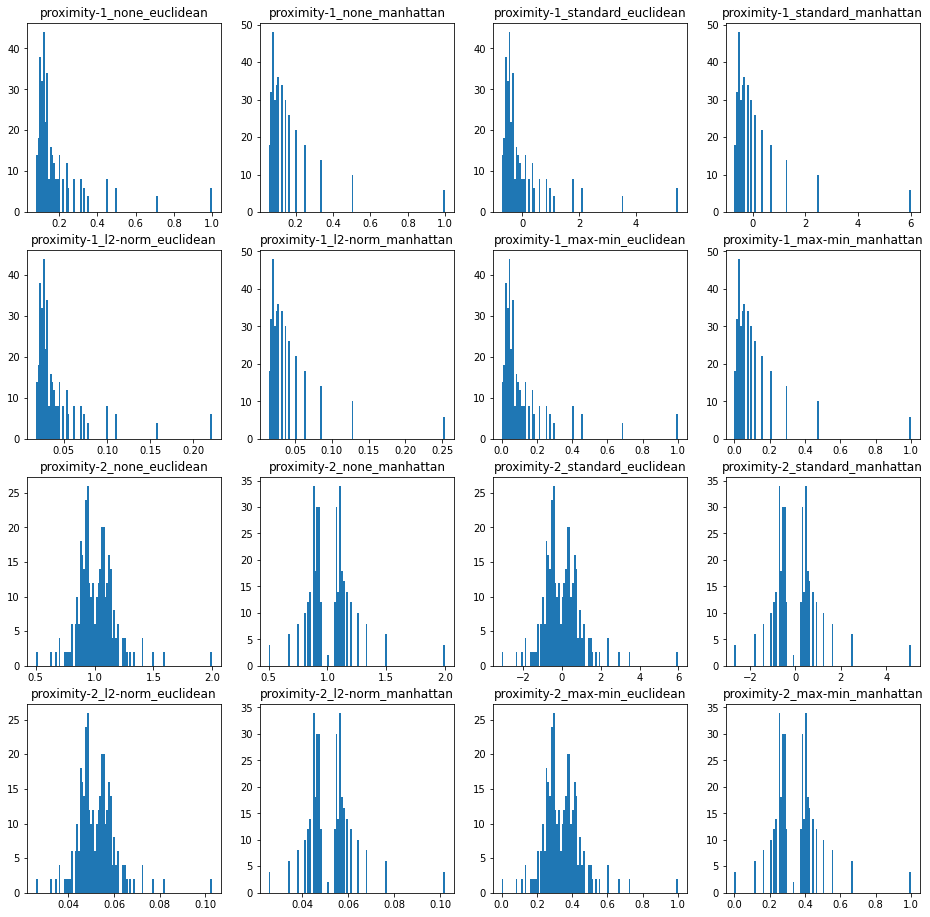

In [18]:
graph = ge.PPGraph(size = 10, tau_0 = 0.1)
dict2plot = get_group_proximities(graph, mode='global')
vis.plot_histograms(dict2plot, bins=100)